# MonkeyGrad.. Like MicroGrad/TinyGrad but built by a monkey

### Note
This code is inspired by Andrej Karpathy's video series on youtube. https://github.com/karpathy/micrograd <br> After watching the video once I am attempting to recreate the code from memory. Hopefully I can turn it into something usable as a fun project.<br><br>- Aryan M

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MLUtils import loadingAnimation, printPurple, plot_function, displayPower
import random

In [23]:
# Value class
class Value:
    """
    Value class that stores a single scalar value and its gradient, also added functions to be able to add/multiply objects.
    
    Attributes:
        value (float): The value of the object
        grad (float): The gradient of the object
        _prev (set): The set of all the previous objects
        _operation (str): The operation that was used to get the value
        _backward (function): The function that is used to back propagate the gradient
        
    Operations:
        __add__: Adds two values together
        __mul__: Multiplies two values together
        __truediv__: Divides two values together
        __pow__: Raises a value to a power
        __neg__: Negates a value

    Back Propagation:
        backProp: Back propagates the gradient through the graph
    
    Activation Functions:
        relu: Applies the ReLU activation function
        tanh: Applies the Tanh activation function
        sigmoid: Applies the Sigmoid activation function
        
    Repr: 
        Returns Value({label}: Data: {value}, Grad: {grad})
    """
    
    def __init__(self, value, _children=(), _op = "", **kwargs):
        self.label = kwargs["label"] if "label" in kwargs else ""
        self.value = value
        self.grad = 0.0
        self._prev = set(_children)
        self._operation = _op
        self._backward = lambda: None
        
    # Arithmatic Operations
        
    def __add__(self, other) -> "Value":
        other = other if isinstance(other, Value) else Value(other) # checks if it is a value at first and if not, it creates a value
        out = Value(self.value + other.value, (self, other), "+")   # adds just the values of the Value data types
        
        def backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = backward
        
        return out
    
    def __mul__(self, other) -> "Value":
        other = other if isinstance(other, Value) else Value(other) # checks if it is a value at first and if not, it creates a value
        out = Value(self.value * other.value, (self, other), "*")
        
        def backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = backward
        return out
    
    def __truediv__(self, other) -> "Value":
        return self.__mul__(other**-1)
    
    def __pow__(self, other) -> "Value":
        assert isinstance(other, (int, float)), "Power must be a number"
        out = Value(self.value**other, (self,), displayPower(self.label if self.label != "" else "(" + str(round(self.value, 6)) + ")", other.label if isinstance(other, Value) and other.label != "" else str(other)))
        
        def backward():
            self.grad += (other * self.value**(other-1)) * out.grad
        out._backward = backward
        
        return out
    
    def __round__(self, other) -> "Value":
        return Value(self.value.__round__(other))
    
    def __neg__(self):
        return self * -1
    
    # Reverse Arithmatic Operations
        
    def __radd__(self, other) -> "Value":
        return self.__add__(other)
    
    def __rmul__(self, other) -> "Value":
        return self.__mul__(other)
    
    def __rtruediv__(self, other) -> "Value":
        return self.__truediv__(other)
    
    def __rpow__(self, other) -> "Value":
        return self.__pow__(other)
    
    # Activation Functions
        
    def relu(self) -> "Value":
        out = Value(0 if self.value < 0 else self.value, (self,), "ReLU")
        
        def backward():
            self.grad += (out.value > 0) * out.grad
        out._backward = backward
        
        return out
    
    def tanh(self) -> "Value":
        out = Value(np.tanh(self.value), (self,), "Tanh")
        
        def backward():
            self.grad += (1 - out.value**2) * out.grad
        out._backward = backward
        
        return out
    
    def sigmoid(self) -> "Value":
        out = Value(1/(1+np.exp(-self.value)), (self,), "Sigmoid")
        
        def backward():
            self.grad += out.value * (1 - out.value) * out.grad
        out._backward = backward
        
        return out
        
    # Back Propagation
    
    def backProp(self) -> None: 
        topo = []
        visited = set()
        def build_topo(v):  # Dont really understand the topo map but need to dive into it further
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __repr__(self):
        return f'Value({self.label + ": " if self.label != "" else self.label}Data: {self.value}, Grad: {self.grad})' # Didnt even know you could add functions like that but glad I tried it

In [37]:
from graphviz import Digraph, render

class Visualizer():
    def __init__(self, root, rankdir = 'LR'):
        self.root = root
        self.nodes, self.edges = self.trace()
        self.format = 'pdf'
        self.rankdir = rankdir
    
    def trace(self):
            nodes, edges = set(), set()
            
            def build(current):
                if current not in nodes:
                    nodes.add(current)
                    for child in current._prev:
                        edges.add((child, current))
                        build(child)
            build(self.root)
            
            return nodes, edges
    
    def __call__(self, output = False):
        drawing = Digraph(format=self.format)
        drawing.attr(rankdir=self.rankdir)  # Set the rankdir attribute here
        
        for node in self.nodes:
            uid = str(id(node))
            label = "{%s | data %.4f | grad %.4f}" % (node.label, node.value, node.grad)
            drawing.node(name=uid, label=label, shape='record')
            
            if node._operation:
                drawing.node(name=uid + node._operation, label=node._operation)
                drawing.edge(uid + node._operation, uid)
                    
        for node1, node2 in self.edges:
            drawing.edge(str(id(node1)), str(id(node2)) + node2._operation)
            
        return drawing

In [25]:
class Neuron:
    '''
    A class to represent a neuron in a neural network.
    
    Attributes:
        weights (list): A list of weights for each input.
        bias (float): A bias value.
        activation (string): The activation function to use.
                Options: 'relu', 'sigmoid', 'tanh'

    '''
    
    def __init__(self, numInp, activation='relu'):
        self.weights = [Value(random.uniform(-1, 1), label = "wi") for i in range(numInp)]
        self.bias = Value(0, label='bias')
        self.activation = activation
        self.inputs = []

    def __call__(self, inputs):
        for i in inputs:
            i = Value(i)
            self.inputs.append(i)
            i.label = 'xi'
            
        wixiTotal = Value(0) ; wixiTotal.label = "wixi"
        for wi, xi in zip(self.weights, inputs):
            wixi = wi * xi ; wixi.label = "wixi"
            wixiTotal += wixi
            wixiTotal.label = "wixi"
        
        total = wixiTotal + self.bias
        total.label = 'total'
        
        if self.activation == 'relu':
            return total.relu()
        elif self.activation == 'sigmoid':
            return total.sigmoid()
        elif self.activation == 'tanh':
            return total.tanh()
        else:
            return total
        
    def parameters(self):
        return self.weights + [self.bias]
    
    def __repr__(self):
        return f'\nInputs: \t{self.inputs} \nWeights: \t{list(map(lambda x: round(x, 4), self.weights))} \nBias: \t\t{[self.bias]}\n'

In [26]:
class Layer:
    def __init__(self, numInput, numNeurons): # numNeurons is the same as specifying the number of outputs
        self.Neurons = [Neuron(numInput) for i in range(numNeurons)]
        
    def __call__(self, x):
        out = [Neuron(x) for Neuron in self.Neurons]
        return out[0] if len(out) == 1 else out # Figuring out Andrej's code here
    
    def parameters(self):
        return [p for n in self.Neurons for p in n.parameters()]
    
    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.Neurons)}]"
    
class MLP():
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

## Testing

In [27]:
# initialize a model 
model = MLP(3, [4, 4, 1]) # 2-layer neural network
print(model)

MLP of [Layer of [
Inputs: 	[] 
Weights: 	[Value(Data: -0.5136, Grad: 0.0), Value(Data: 0.9038, Grad: 0.0), Value(Data: -0.7394, Grad: 0.0)] 
Bias: 		[Value(bias: Data: 0, Grad: 0.0)]
, 
Inputs: 	[] 
Weights: 	[Value(Data: 0.8615, Grad: 0.0), Value(Data: 0.5627, Grad: 0.0), Value(Data: -0.8754, Grad: 0.0)] 
Bias: 		[Value(bias: Data: 0, Grad: 0.0)]
, 
Inputs: 	[] 
Weights: 	[Value(Data: -0.8061, Grad: 0.0), Value(Data: 0.1287, Grad: 0.0), Value(Data: 0.6191, Grad: 0.0)] 
Bias: 		[Value(bias: Data: 0, Grad: 0.0)]
, 
Inputs: 	[] 
Weights: 	[Value(Data: 0.5361, Grad: 0.0), Value(Data: -0.2577, Grad: 0.0), Value(Data: 0.5183, Grad: 0.0)] 
Bias: 		[Value(bias: Data: 0, Grad: 0.0)]
], Layer of [
Inputs: 	[] 
Weights: 	[Value(Data: -0.3038, Grad: 0.0), Value(Data: 0.6807, Grad: 0.0), Value(Data: -0.739, Grad: 0.0), Value(Data: -0.6521, Grad: 0.0)] 
Bias: 		[Value(bias: Data: 0, Grad: 0.0)]
, 
Inputs: 	[] 
Weights: 	[Value(Data: 0.3337, Grad: 0.0), Value(Data: 0.8351, Grad: 0.0), Value(Data: 0

In [28]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [model(x) for x in xs]
ypred

[Value(Data: 0, Grad: 0.0),
 Value(Data: 0.7836397958213619, Grad: 0.0),
 Value(Data: 0.19901548017040366, Grad: 0.0),
 Value(Data: 0, Grad: 0.0)]

In [29]:
loss = sum((yOut + (-yGroundTruth)) ** 2 for yGroundTruth, yOut in zip(ys, ypred))
loss.label = "Loss"
loss.backProp()

Value(Loss: Data: 6.619009042925933, Grad: 1)


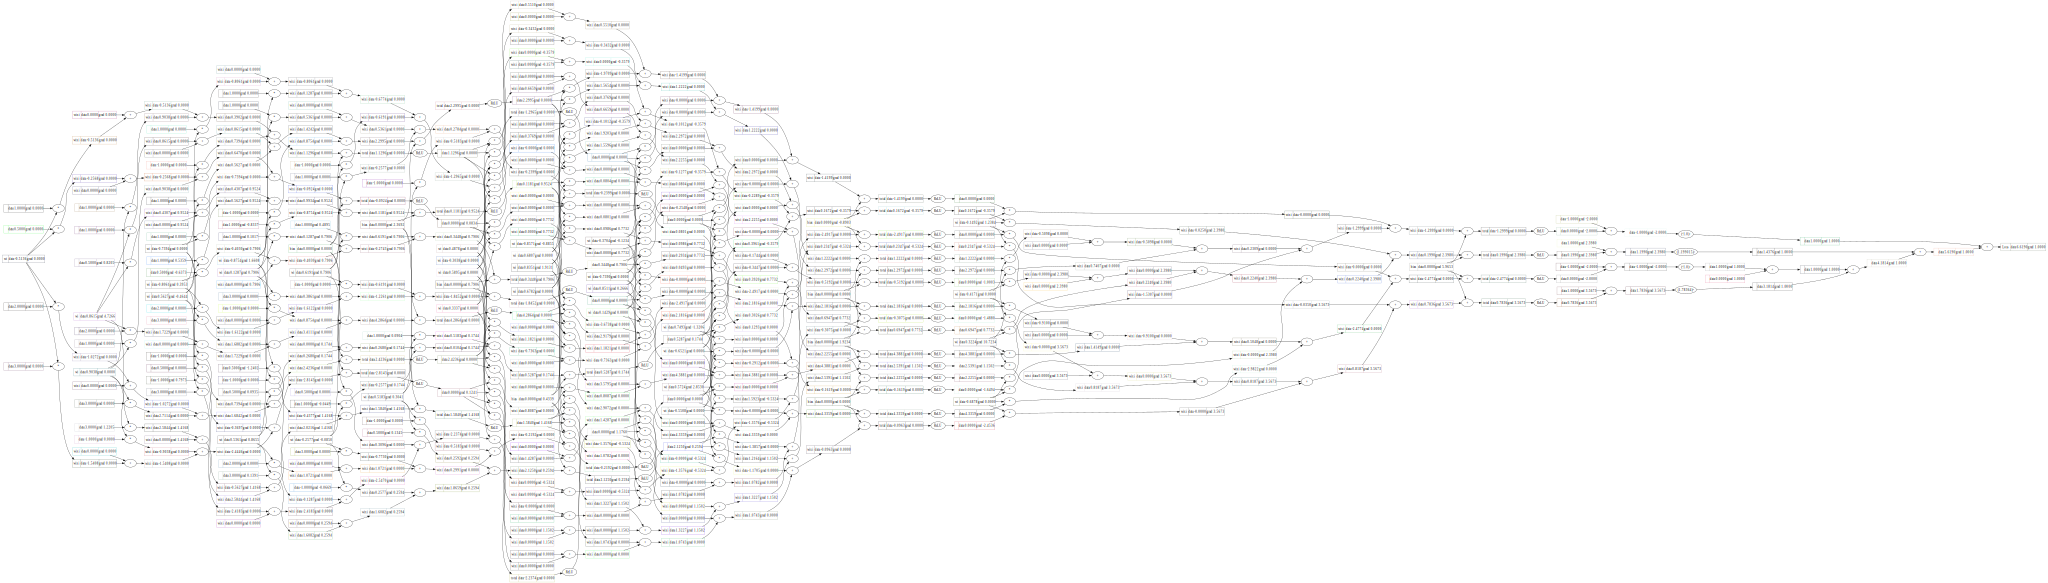

In [38]:
# DONT RUN THIS EVERY TIME IT TAKES A LONG TIME
# Visualize the model
print(loss)
Visualizer(loss)(True)

In [31]:
x = [Value(1.0), Value(-2.0)]   # Input parameters
neuron = Neuron(len(x), 'tanh') # Create a neuron with 2 inputs and tanh activation function
y = neuron(x)                   # Output of the neuron
y.backProp() # Perform backpropagation to calculate the gradients

Neuron: 
Inputs: 	[Value(xi: Data: Value(Data: 1.0, Grad: -0.08462794238748521), Grad: 0.0), Value(xi: Data: Value(Data: -2.0, Grad: 0.09197673476921926), Grad: 0.0)] 
Weights: 	[Value(Data: -0.4752, Grad: 0.0), Value(Data: 0.5164, Grad: 0.0)] 
Bias: 		[Value(bias: Data: 0, Grad: 0.17810322955871094)]



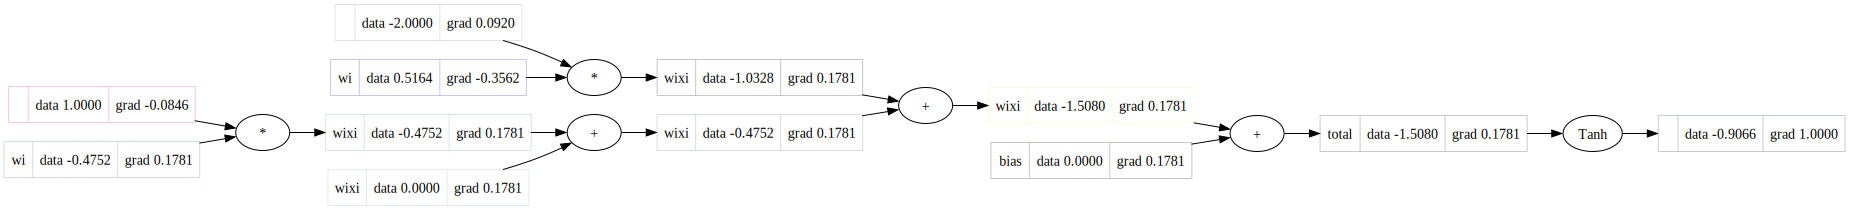

In [32]:

print("Neuron:",neuron)
Visualizer(y)()

In [33]:
printPurple("\nDockstring for Value Class: ")
print(Value.__doc__)                           # added docstring


Dockstring for Value Class: 

    Value class that stores a single scalar value and its gradient, also added functions to be able to add/multiply objects.
    
    Attributes:
        value (float): The value of the object
        grad (float): The gradient of the object
        _prev (set): The set of all the previous objects
        _operation (str): The operation that was used to get the value
        _backward (function): The function that is used to back propagate the gradient
        
    Operations:
        __add__: Adds two values together
        __mul__: Multiplies two values together
        __truediv__: Divides two values together
        __pow__: Raises a value to a power
        __neg__: Negates a value

    Back Propagation:
        backProp: Back propagates the gradient through the graph
    
    Activation Functions:
        relu: Applies the ReLU activation function
        tanh: Applies the Tanh activation function
        sigmoid: Applies the Sigmoid activation fun

In [34]:
# Testing the prototype for the Value class

x = Value(2.0)  ; x.label = 'x'
y = Value(0.38462)  ; y.label = 'y'
j = Value(3.0) ; j.label = 'j'

z = y **2   ; z.label = 'z'
f = ((z + x) / 34)  ; f.label = 'f'
h = f.tanh() ; h.label = 'h'


printPurple(f'\n{z}')
print("z Previous: " , z._prev)
printPurple(f)
print("f Previous: ", f._prev)       
printPurple(h)
print("h Previous: ", h._prev) # Added _prev to track children

printPurple("\nTesting radd and rmul:")
print(2.0 + x, "\t",x + 2.0)                    # Added radd
print(6.0 * x, "\t", x * 6.0)                   # Added rmul

h.backProp() # Dont call backProp far from


Value(z: Data: 0.1479325444, Grad: 0.0)
z Previous:  {Value(y: Data: 0.38462, Grad: 0.0)}
Value(f: Data: 0.06317448660000001, Grad: 0.0)
f Previous:  {Value(Data: 2.1479325444, Grad: 0.0), Value(Data: 0.029411764705882353, Grad: 0.0)}
Value(h: Data: 0.0630905770939617, Grad: 0.0)
h Previous:  {Value(f: Data: 0.06317448660000001, Grad: 0.0)}

Testing radd and rmul:
Value(Data: 4.0, Grad: 0.0) 	 Value(Data: 4.0, Grad: 0.0)
Value(Data: 12.0, Grad: 0.0) 	 Value(Data: 12.0, Grad: 0.0)


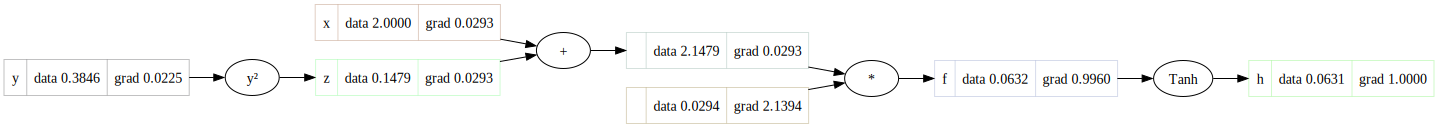

In [35]:
v = Visualizer(h)
v() # I think this can be cleaner but I dont know how at the moment

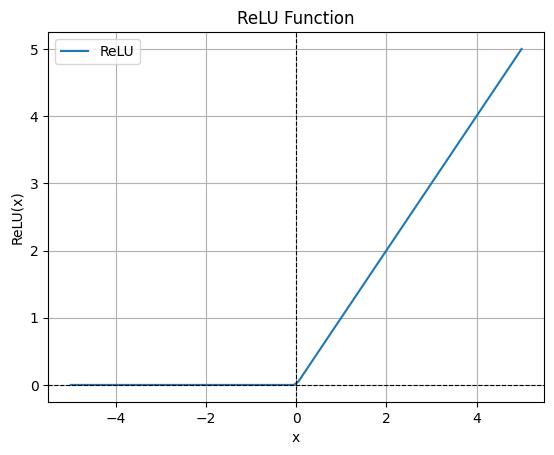

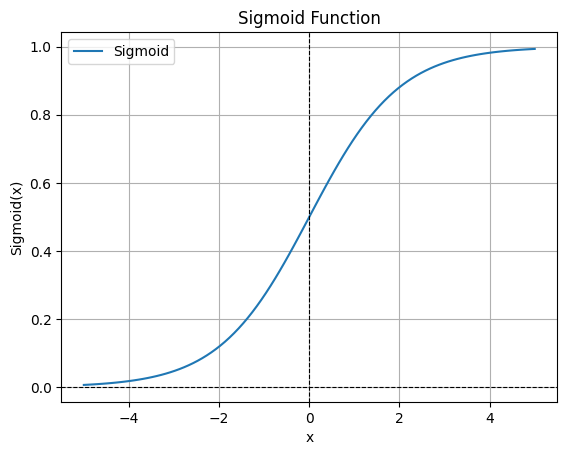

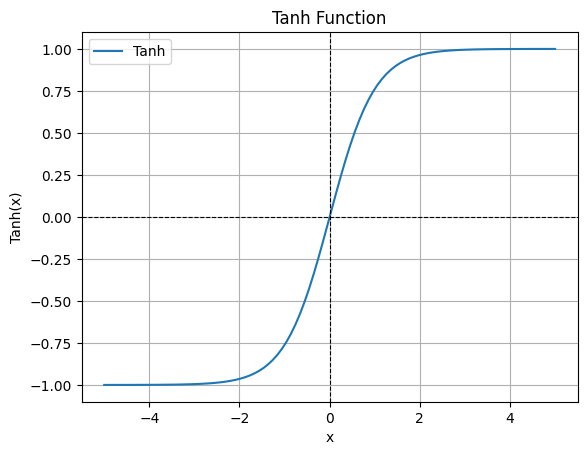

In [36]:
# making a graphical representation of a different activation functions

def printActivationFunctions():
    def relu(x):
        return np.maximum(0, x)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def tanh(x):
        return np.tanh(x)

    plot_function(relu, 'ReLU')
    plot_function(sigmoid, 'Sigmoid')
    plot_function(tanh, 'Tanh')

printActivationFunctions()